**This Dataset is taken from the official NIH Website**: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

In [1]:
import warnings
warnings.filterwarnings(action="ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from matplotlib.image import imread

# Importing and Visualizing the data

In [3]:
# Relative path to data
data_dir = "DATA/cell_images"

train_data_path = os.path.join(data_dir, "train")
test_data_path = os.path.join(data_dir, "test")

In [4]:
total_num_of_images = 0

paths = [
    os.path.join(train_data_path, "parasitized"),
    os.path.join(train_data_path, "uninfected"),
    os.path.join(test_data_path, "parasitized"),
    os.path.join(test_data_path, "uninfected")
    
]

for path in paths:
    total_num_of_images += len(os.listdir(path))
    
print("Total number of images:", total_num_of_images)

Total number of images: 27560


In [5]:
infected_cell_img_ex_name = os.listdir(os.path.join(train_data_path, "parasitized"))[0]
normal_cell_img_ex_name = os.listdir(os.path.join(train_data_path, "uninfected"))[0]

In [6]:
infected_cell_img_ex_path = os.path.join(train_data_path, os.path.join("parasitized", infected_cell_img_ex_name))
normal_cell_img_ex_path = os.path.join(train_data_path, os.path.join("uninfected", normal_cell_img_ex_name))

Let's take a look at how a malaria infected cell looks like:

In [7]:
infected_cell_img_ex = imread(infected_cell_img_ex_path)

print(infected_cell_img_ex.shape)
print(infected_cell_img_ex.min(), infected_cell_img_ex.max())

(121, 118, 3)
0.0 0.78039217


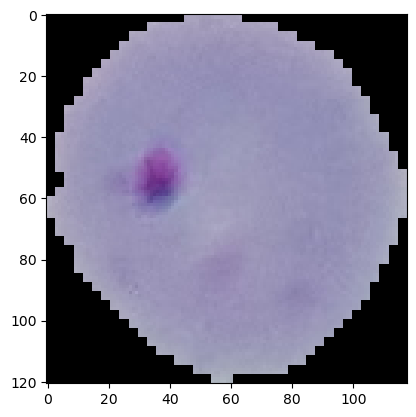

In [8]:
_ = plt.imshow(infected_cell_img_ex)

For reference, let's have a look at a normal cell:

In [9]:
normal_cell_img_ex = imread(normal_cell_img_ex_path)

print(normal_cell_img_ex.shape)
print(normal_cell_img_ex.min(), normal_cell_img_ex.max())

(127, 115, 3)
0.0 0.8862745


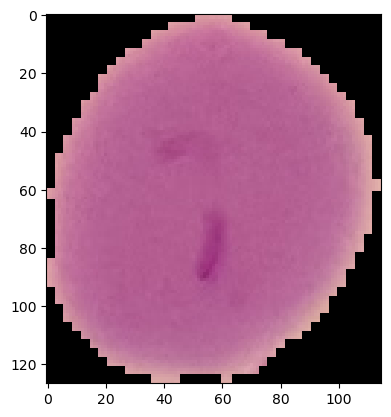

In [10]:
_ = plt.imshow(normal_cell_img_ex)

Let's now check how many images we have for each one of the classes, i.e. healthy vs non-healthy cells:

In [11]:
print("Nr. of parasitized cell images (for training): {}\nNr. of normal cell images (for training): {}"
      .format(
          len(os.listdir(os.path.join(train_data_path, "parasitized"))),
          len(os.listdir(os.path.join(train_data_path, "uninfected")))
      )
)

Nr. of parasitized cell images (for training): 12480
Nr. of normal cell images (for training): 12480


In [12]:
print("Nr. of parasitized cell images (for testing): {}\nNr. of normal cell images (for testing): {}"
      .format(
          len(os.listdir(os.path.join(test_data_path, "parasitized"))),
          len(os.listdir(os.path.join(test_data_path, "uninfected")))
      )
)

Nr. of parasitized cell images (for testing): 1300
Nr. of normal cell images (for testing): 1300


As we saw, not all images have the same dimensions/shape. This is a problem since the convolutional neural network will not be able to train on images of various sizes.

We need to make sure that we're going to resize all these images to be the same size. So we have to choose what actual dimension should we resize everything to.

What we are going to choose is the average of both dimensions. So if we're dealing with an image that has a smaller size than the average then we can add padding so that it reaches these dimensions, and if it's a larger image we can either crop it or shrink it down.


Let's check out what this average value would be.

In [13]:
dim1, dim2 = [], []

for image_filename in os.listdir(os.path.join(test_data_path, "uninfected")):
    
    img = imread(os.path.join(test_data_path, os.path.join("uninfected", image_filename)))
    img_width, img_height, img_colour_channels = img.shape
    
    dim1.append(img_width)
    dim2.append(img_height)

In [14]:
print(int(np.mean(dim1)), int(np.mean(dim2)))

130 130


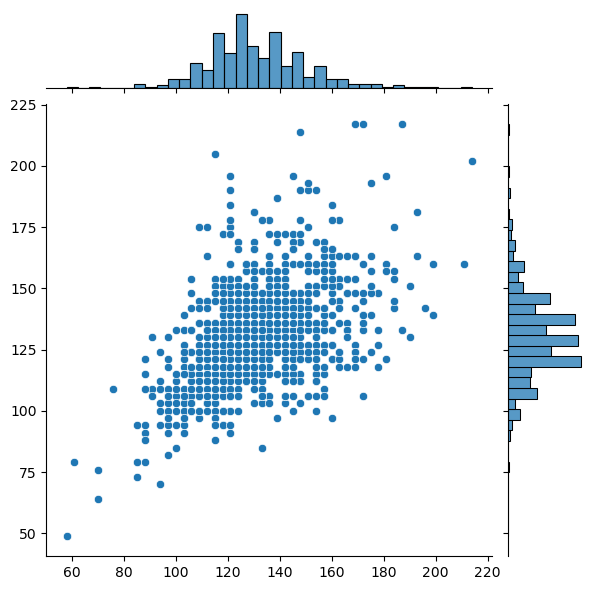

In [15]:
_ = sns.jointplot(dim1, dim2)

In [16]:
image_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 3)
image_shape

(130, 130, 3)

# Image manipulation

For each image we have $(130 \times 130 \times 3) = 50700$ datapoints. Because of that we're not going to be able to just feed in everything at once. Instead, we will have to select batches of our images.

Our model should also be robust enough to deal with images that are quite different from images that it has seen before. One way to do that is by manipulating and performing transformations on our images (e.g. rotation, resizing, scaling).

Finally, our entire data set is less that 30000 images. What we want to be able to do is to expand the amount of images without having to gather more data. What we can do instead is do things like take our current images and randomly rotate them by some amount of degrees, randomly shift the width and/or height of the image by some percentage. What would be considered a good value to choose for things like rotation and shifting depends on what kind of images we are dealing with.

In our case, we are lucky in the sense that our images look like blobs, so we can expect that future images of red blood cells will kind of look like these blobs, i.e. circular in nature and that they can be stretched or squished in future images. This means we can be more liberal with our choice of rotation degrees and width/height shift.

This might not be true for other kind of images, e.g. images for facial data. In that case, we don't want to be squeezing or rotating faces so much that they're in unrealistic positions.

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
# help(ImageDataGenerator)

In [19]:
# Rotate images by 20 degrees, 
# Shift width and height randomly between 0 and 10%
# Cut away part of the image (shear maximum of 10%)
# Randomly zoom in and allow for horizontal flip of an image
# Take the nearest values of pixels to fill-in the stretched out areas
# Our images are already normalized, so we don't need to use the rescale parameter
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode="nearest"
                               # rescale=1/255
                               
            )

To understand how this works let's make an example of random transformations based on the restrictions we imposed above.

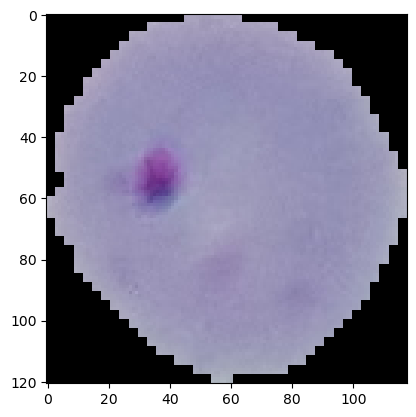

In [20]:
_ = plt.imshow(infected_cell_img_ex)

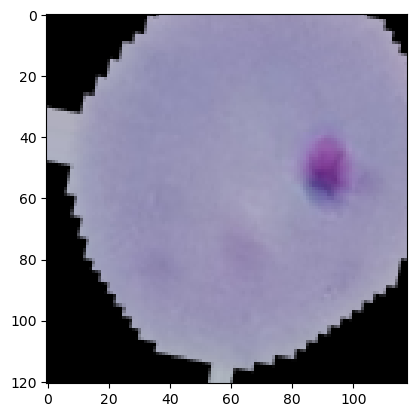

In [21]:
_ = plt.imshow(
    image_gen.random_transform(infected_cell_img_ex)
)

We can now apply these random transformationw on the entirety of our data set and essential double its size. We can even do multiple random transorfmations on each image and vastly increase the size of our data set.

We can use the ``.flow_from_directory`` method to generate many manipulated images from a directory. In order to use this method, **we must organize the images in sub-directories**. The sub-directories should only contain images of one class, so one folder per class of images.

In [22]:
image_gen.flow_from_directory(train_data_path)

Found 24958 images belonging to 2 classes.


# Building a CNN model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

In [61]:
model = Sequential()

model.add(
    Conv2D(
        filters=32,
        kernel_size=(3,3),
        input_shape=image_shape,
        activation="relu"
    )
)
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=64,
        kernel_size=(3,3),
        input_shape=image_shape,
        activation="relu"
    )
)
model.add(MaxPool2D(pool_size=(2,2)))

model.add(
    Conv2D(
        filters=128,
        kernel_size=(3,3),
        input_shape=image_shape,
        activation="relu"
    )
)
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

# OUTPUT LAYER
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [62]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 31, 31, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 14, 14, 128)      

In [63]:
from tensorflow.keras.callbacks import EarlyStopping

In [64]:
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)

In [65]:
# Batch size for training
batch_size=64

In [66]:
# Create two generators

train_image_gen = image_gen.flow_from_directory(
    train_data_path,
    target_size=image_shape[:2],
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
)


test_image_gen = image_gen.flow_from_directory(
    test_data_path,
    target_size=image_shape[:2],
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False,
)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


**Class 0** : malaria-infected red blood cells
<br>
**Class 1** : normal red blood cells

In [67]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [68]:
results = model.fit_generator(
    train_image_gen, 
    epochs=20,
    validation_data=test_image_gen,
    callbacks=[early_stop]
)

Epoch 1/20
390/390 [==============================] - 276s 705ms/step - loss: 1.0868 - accuracy: 0.5386 - val_loss: 0.6776 - val_accuracy: 0.5738
Epoch 2/20
390/390 [==============================] - 274s 702ms/step - loss: 0.6784 - accuracy: 0.5739 - val_loss: 0.6703 - val_accuracy: 0.6062
Epoch 3/20
390/390 [==============================] - 259s 662ms/step - loss: 0.6725 - accuracy: 0.5885 - val_loss: 0.6630 - val_accuracy: 0.6031
Epoch 4/20
390/390 [==============================] - 256s 657ms/step - loss: 0.6673 - accuracy: 0.6037 - val_loss: 0.6339 - val_accuracy: 0.6431
Epoch 5/20
390/390 [==============================] - 259s 664ms/step - loss: 0.6812 - accuracy: 0.5809 - val_loss: 0.6749 - val_accuracy: 0.5846
Epoch 6/20
390/390 [==============================] - 255s 653ms/step - loss: 0.6715 - accuracy: 0.5971 - val_loss: 0.6701 - val_accuracy: 0.5935
Epoch 6: early stopping


# Evaluating the Model

In [69]:
metrics = pd.DataFrame(model.history.history)
metrics.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')

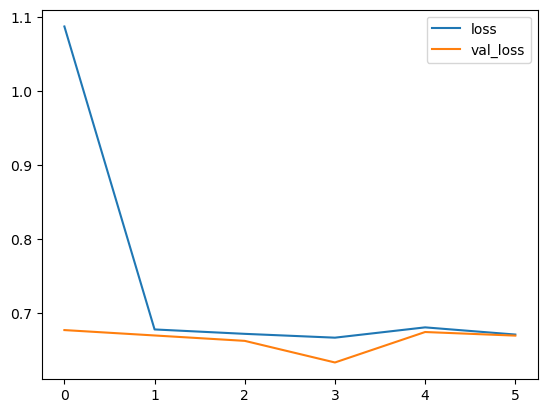

In [70]:
_ = metrics[["loss", "val_loss"]].plot()

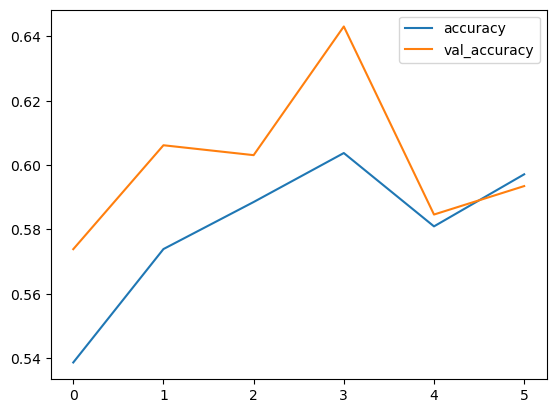

In [71]:
_ = metrics[["accuracy", "val_accuracy"]].plot()

In [72]:
model.evaluate_generator(test_image_gen)

[0.671761691570282, 0.5888461470603943]

In [73]:
pred_probabilities = model.predict_generator(test_image_gen)

predictions = (pred_probabilities > 0.5).astype("int32")

In [74]:
from sklearn.metrics import classification_report,confusion_matrix

In [75]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.56      0.84      0.67      1300
           1       0.68      0.33      0.45      1300

    accuracy                           0.59      2600
   macro avg       0.62      0.59      0.56      2600
weighted avg       0.62      0.59      0.56      2600



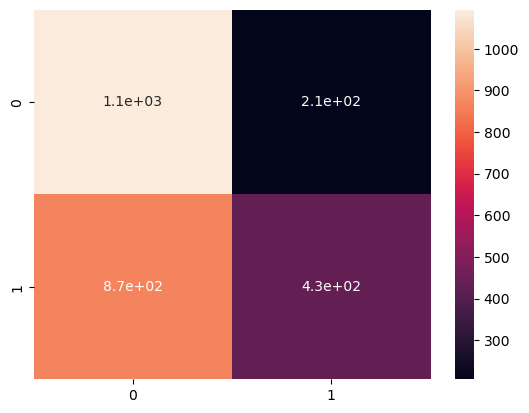

In [76]:
_ = sns.heatmap(confusion_matrix(test_image_gen.classes, predictions), annot=True)

In [77]:
print(confusion_matrix(test_image_gen.classes, predictions))

[[1094  206]
 [ 867  433]]


## Model Performance Review

### Classification Report

The classification report provides insights into the model's performance for binary classification of malaria-infected red blood cells (Class 0) and normal red blood cells (Class 1).

- **Class 0 (Malaria-infected cells):**
  - Precision: 0.56
  - Recall: 0.84
  - F1-score: 0.67

- **Class 1 (Normal red blood cells):**
  - Precision: 0.68
  - Recall: 0.33
  - F1-score: 0.45

- **Overall:**
  - Accuracy: 59%


### Confusion Matrix

The confusion matrix further details the model's performance:


- **True Positives (TP):**
  - Class 0: 1094
  - Class 1: 433

- **False Positives (FP):**
  - Class 1: 206

- **False Negatives (FN):**
  - Class 0: 206
  - Class 1: 867

### Interpretation

The model demonstrates better performance in identifying malaria-infected cells (Class 0) with high precision and recall. However, it faces challenges in recognizing normal red blood cells (Class 1), particularly with a lower recall. The confusion matrix highlights instances of false positives and false negatives, indicating areas for improvement.

### Comment on Overall Accuracy

The overall accuracy of the model is 59%. It's noteworthy that a random classification would result in an accuracy of 50%. Therefore, the model's accuracy is slightly better than random, but careful consideration of class-specific metrics is crucial for a comprehensive evaluation.


### Conclusion

While the model achieves an overall accuracy of 59%, attention to class-specific metrics reveals opportunities for refinement. There's a need to improve recall for normal red blood cells, as evidenced by a higher number of false negatives.


# Predicting on an Image

In [81]:
from tensorflow.keras.preprocessing import image

In [100]:
my_image_class_path = paths[np.random.randint(0, 2)]
my_image_path = os.path.join(
        my_image_class_path,
        os.listdir(my_image_class_path)[np.random.randint(0, len(os.listdir(my_image_class_path)))],
    )

my_image = image.load_img(my_image_path, target_size=image_shape)


print(type(my_image))

<class 'PIL.Image.Image'>


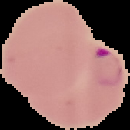

In [101]:
my_image

In [102]:
# Convert Pillow image to NumPy array
my_image = image.img_to_array(my_image)

In [103]:
print(my_image.shape)

(130, 130, 3)


In [104]:
my_image = my_image.reshape(1,130,130,3)

In [105]:
print(my_image.shape)

(1, 130, 130, 3)


In [106]:
y_pred = (model.predict(my_image) > 0.5).astype("int32")

1/1 [==============================] - 0s 49ms/step


In [107]:
y_pred

array([[0]], dtype=int32)

In [109]:
print(my_image_path)

DATA/cell_images/train/parasitized/C129P90ThinF_IMG_20151004_134700_cell_22.png
